# **Exercício 4 - CNN** (2024 - $1^o$ semestre)

|Alunos da Dupla                   |NUSP    |E-mail USP       |
|----------------------------------|--------|-----------------|
|Gustavo Henrique da Silva Amaral  |12551686|gustavo.amaral7@usp.br|
|Thiago da Rocha Calomino Gonçalves|12554647|thcalomino@usp.br|

Link: [Enunciado do Exercício 4 - CNN](https://psi3471.github.io/ex_entrega_4.html)

# Instalação de dependências

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import datasets, transforms

# Definição dos hiperparâmetros

In [ ]:
# passo de adaptação
eta = 0.001

# Tamanho do mini-batch
Nb = 120

# Tamanho do mini-batch usado no teste
Nb_test = 10000

# Número de épocas
Ne = 10

#Definir quais das redes usar:
redeComThreshold = '0' # = '0' para não utilizar Threshold de 0.25

# Importação dos dados e análise prévia

Usaremos o banco de dados _Fashion MNIST_ e implementar um classificador multiclasse usando uma CNN. São 70000 imagens 28x28 de peças de vestuário distribuídas em 10 classes, divididas em um conjunto de treinamento com 60000 imagens e um de teste com 10000.

Aqui temos um exemplo da CNN com PyTorch, substituindo a parte de carregamento de dados do MNIST, para o Fashion MNIST, como abaixo:

In [ ]:
Nb = 64

dir_data = "~/temp"


## Carregando dados de treinamento
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        dir_data,
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor()]
        ),
    ),
    batch_size=Nb,
    shuffle=True,
)

## Carregando dados de teste
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        dir_data,
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor()]
        ),
    ),
    batch_size=Nb_test,
    shuffle=True,
)

100%|██████████| 26421880/26421880 [00:09<00:00, 2722516.00it/s]


Extracting /root/temp/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/temp/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 159124.91it/s]


Extracting /root/temp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/temp/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2892442.97it/s]


Extracting /root/temp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/temp/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6613254.82it/s]

Extracting /root/temp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/temp/FashionMNIST/raw



Exibição das imagens da base de dados

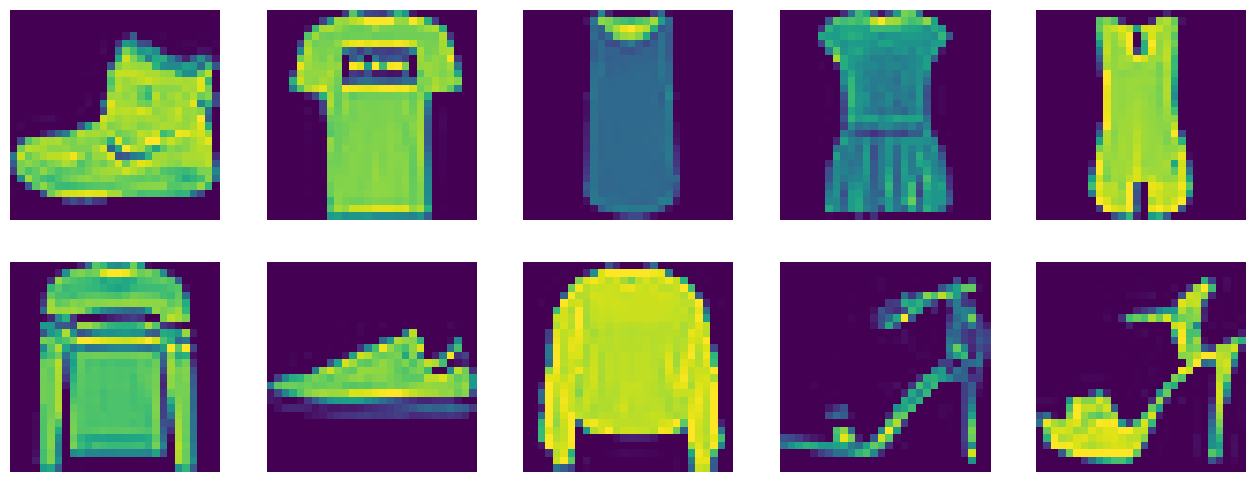

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

Imagens com threshold

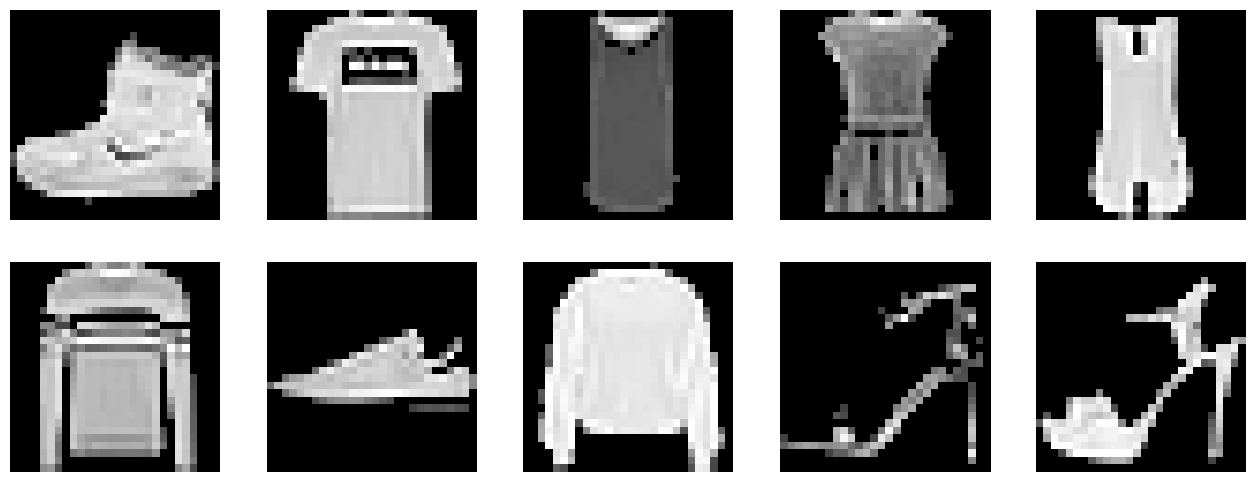

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)

    image = image * np.where(image >  0.25, 1, 0).astype(int)

    plt.imshow(image.squeeze(), cmap = 'gray')
    plt.axis('off');

# Definição da rede

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Primeira camada convolucional: aplica 16 filtros de tamanho 5x5 com padding de 2.
        # O padding mantém a dimensão da imagem original de 28x28, mesmo após a convolução.
        # A função de ativação LeakyReLU é utilizada para introduzir não-linearidade,
        # enquanto Batch Normalization ajuda a estabilizar e acelerar o treinamento.
        # A camada de Max Pooling de 2x2 reduz as dimensões espaciais pela metade para 14x14.
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
        )

        # Segunda camada convolucional: aumenta o número de canais de 16 para 32,
        # mantendo o tamanho da imagem devido ao padding de 2.
        # Após a convolução e ativação, o pooling reduz novamente o tamanho da imagem para 7x7.
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )

        # Terceira camada convolucional: aumenta o número de canais para 64,
        # utilizando um kernel de tamanho 3x3 com padding de 1 para manter o tamanho de 7x7.
        # Após a ativação e normalização, o pooling reduz o tamanho para 3x3.
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),  # Menor kernel para focar em detalhes mais finos.
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )

        # Camada de dropout com probabilidade de 0.5 para reduzir o risco de sobreajuste,
        # desativando aleatoriamente a metade das conexões durante o treinamento.
        self.dropout = nn.Dropout(0.5)

        # Camada totalmente conectada que mapeia as características extraídas (64 canais de 3x3 cada)
        # para 10 classes de saída, correspondentes às categorias de classificação.
        self.out = nn.Linear(64 * 3 * 3, 10)

    def forward(self, x):
        # Processamento sequencial das camadas convolucionais.
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flattening: transforma a matriz 3D resultante das camadas convolucionais em um vetor 1D.
        x = x.view(x.size(0), -1)  # Redimensiona o tensor para o formato apropriado para a camada totalmente conectada.

        # Aplica dropout antes da passagem pela camada totalmente conectada.
        x = self.dropout(x)

        # Gera as saídas finais para cada classe.
        output = self.out(x)
        return output


Modelo com threshold

In [ ]:
class ModelThreshold(nn.Module):
    def __init__(self):
        super().__init__()

        # Primeira camada convolucional: usa um filtro de tamanho 5x5 com padding de 2 para manter a dimensão da imagem.
        # A camada aplica 16 filtros, transformando a entrada de 1 canal (imagem em escala de cinza) para 16 canais.
        # Após a ReLU e o Batch Normalization para estabilização, um MaxPooling reduz pela metade a dimensão espacial.
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),  # Aplica a função de ativação ReLU para adicionar não-linearidade
            nn.BatchNorm2d(16),  # Normaliza as ativações da camada para melhorar a estabilidade do treinamento
            nn.MaxPool2d(kernel_size=2),  # Reduz a dimensão espacial pela metade (de 28x28 para 14x14)
        )

        # Segunda camada convolucional: segue um padrão similar à primeira camada, aumentando o número de canais para 32.
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),  # Continua a redução dimensional para 7x7
        )

        # Terceira camada convolucional: aumenta ainda mais os canais para 64, usando um filtro de 3x3.
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),  # Padding de 1 mantém a dimensão espacial antes do pooling.
            nn.LeakyReLU(),  # Variante do ReLU que permite um pequeno gradiente quando a unidade está inativa.
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  # Reduz para 3x3
        )

        # Dropout para reduzir o sobreajuste, desligando aleatoriamente 50% das conexões durante o treinamento.
        self.dropout = nn.Dropout(0.5)

        # Camada totalmente conectada que mapeia as características (64 canais de 3x3 cada) para 10 classes de saída.
        self.out = nn.Linear(64 * 3 * 3, 10)

        # Thresholding ativo para modificar a entrada de pixels; valores abaixo de 0.25 são ajustados para 0.
        self.threshold = nn.Threshold(0.25, 0.0)

    def forward(self, x):
        # Processa a entrada através do threshold.
        x = self.threshold(x)

        # Processamento sequencial através das camadas convolucionais e de pooling.
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)

        output = self.out(x)
        return output


In [ ]:
# Configuração do dispositivo de computação
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instanciação do modelo
if redeComThreshold == '1':
    model = ModelThreshold().to(device)
else:
    model = Model().to(device)

# Definição da função de custo
loss_function = nn.CrossEntropyLoss()

# Definição do otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

# Definição do escalonador de taxa de aprendizado


# Treinamento da rede

Época: 0 [0/60000 (0%)]	Loss: 2.891494
Época: 0 [6400/60000 (11%)]	Loss: 0.595779
Época: 0 [12800/60000 (21%)]	Loss: 0.552472
Época: 0 [19200/60000 (32%)]	Loss: 0.339799
Época: 0 [25600/60000 (43%)]	Loss: 0.388459
Época: 0 [32000/60000 (53%)]	Loss: 0.491165
Época: 0 [38400/60000 (64%)]	Loss: 0.463671
Época: 0 [44800/60000 (75%)]	Loss: 0.278947
Época: 0 [51200/60000 (85%)]	Loss: 0.415755
Época: 0 [57600/60000 (96%)]	Loss: 0.360417
Época: 1 [0/60000 (0%)]	Loss: 0.543380
Época: 1 [6400/60000 (11%)]	Loss: 0.366541
Época: 1 [12800/60000 (21%)]	Loss: 0.407801
Época: 1 [19200/60000 (32%)]	Loss: 0.315331
Época: 1 [25600/60000 (43%)]	Loss: 0.302116
Época: 1 [32000/60000 (53%)]	Loss: 0.268149
Época: 1 [38400/60000 (64%)]	Loss: 0.353734
Época: 1 [44800/60000 (75%)]	Loss: 0.352639
Época: 1 [51200/60000 (85%)]	Loss: 0.531493
Época: 1 [57600/60000 (96%)]	Loss: 0.337888
Época: 2 [0/60000 (0%)]	Loss: 0.473894
Época: 2 [6400/60000 (11%)]	Loss: 0.355540
Época: 2 [12800/60000 (21%)]	Loss: 0.147436
Época:

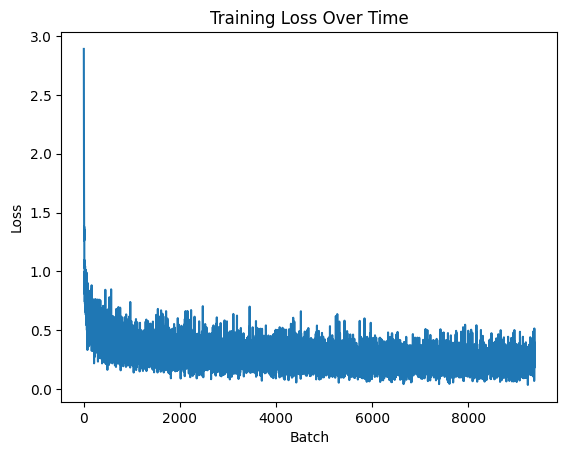

In [ ]:
import matplotlib.pyplot as plt

# Lista para armazenar as perdas
losses = []

# Loop principal de treinamento
for epoch in range(Ne):
    for n, (X, d) in enumerate(train_loader):
        # Move os dados para o dispositivo apropriado (GPU ou CPU)
        X, d = X.to(device), d.to(device)

        # Ajusta as dimensões para corresponder ao esperado pela rede
        X = X.view(-1, 1, 28, 28)

        # Ativa o modo de treinamento
        model.train()

        # Zera os gradientes do otimizador (boa prática em vez de model.zero_grad())
        optimizer.zero_grad()

        # Passagem para frente: calcula a previsão do modelo e a perda
        y = model(X)
        loss = loss_function(y, d)

        # Passagem para trás: calcula os gradientes e atualiza os pesos
        loss.backward()
        optimizer.step()

        # Armazena a perda
        losses.append(loss.item())

        # Exibe informações sobre o treinamento
        if n % 100 == 0:
            total = len(train_loader.dataset)
            completed = n * len(X)
            percentage = 100. * n / len(train_loader)
            print(f"Época: {epoch} [{completed}/{total} ({percentage:.0f}%)]\tLoss: {loss:.6f}")

# Visualização das perdas após o treinamento
plt.figure()
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()


# Inferência com testes

In [13]:
# Variável usada para contabilizar o número de acertos
correct = 0

# Loop dos mini batches
for n, (X, d) in enumerate(test_loader):
    # Envia os dados para a GPU, caso ela exista
    X = X.to(device=device)
    d = d.to(device=device)

    # Ajuste de dimensões
    X = X.view(-1, 1, 28, 28)

    # Coloca o modelo em modo de inferência
    model.eval()

    # Calcula a saída
    y = model(X)

    # Cálculo do número de acertos:
    # 1) Obtém o índice do elemento máximo para cada exemplo do minibatch
    pred = torch.max(y, 1, keepdim=True)[1]
    # 2) Conta o número de acertos e acumula na variável correct
    # pred.eq(d.view_as(pred)) é um tensor booleano. Dessa forma, o número de
    # acertos é obtido somando seus elementos. Valores True são tratados como 1.
    correct += pred.eq(d.view_as(pred)).cpu().sum().item()

# Mostra o desempenho obtido no teste
accuracy = 100. * correct / len(test_loader.dataset)
print(f"Acurácia: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)")

Acurácia: 9036/10000 (90.36%)
